In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-934b5783-2b2a-deaa-f171-1854446a70a5)


In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
%%capture
!pip install transformers

In [4]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

In [5]:
train_data = pd.read_csv("drive/MyDrive/Internship/datasets/Goud/train_preprocessed.csv")
val_data = pd.read_csv("drive/MyDrive/Internship/datasets/Goud/validation_preprocessed.csv")
test_data = pd.read_csv("drive/MyDrive/Internship/datasets/Goud/test_preprocessed.csv")

In [ ]:
# train_data.drop_duplicates(inplace=True, ignore_index=True)
# val_data.drop_duplicates(inplace=True, ignore_index=True)
# test_data.drop_duplicates(inplace=True, ignore_index=True)

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
train_data

,headline,categories
0,حكم ضد وزارة اعمارة بتعويض قدره 13 مليار لشركة,"('جورنالات بلادي',)"
1,جلسة خاصة بين مدرب الأهلي ومهاجم الأسود أزارو,"('كود سبور',)"
2,اعتقال مهاجم الريال رونالدو في فرنسا… وها علاش (صور),"('كود سبور',)"
3,الأسود المحليين يستعدون للمربع الذهبي,"('كود سبور',)"
4,الجديد.. ريحة ديال المازوط وليصونس لعشاق صوكَان وطوموبيلات,"('تبركيك',)"
...,...,...
62005,واش دخلو الصهد؟. امحند العنصر لـ”كود”: مزال مقررت نترشح للأمانة العامة ديال الحركة الشعبية وها وقتاش غادي نقرر,"('تبركيك',)"
62006,الفنانة المغربية ابتسام تسكت مطلوبة بوجدة‏,"('الزين والحداكة',)"
62007,من بعد 15 العام.. تصوير تتمة فيلم “ماروك” لي كان نوض روينة,"('ميديا وثقافة',)"
62008,جورنالات بلادي1. غموض يلف صرف 5 ملايير بمؤسسة الأعمال الاجتماعية بوزارة الصحة وأمن طنجة يعتقل زعيم عصابة بتهمة اختطاف زوجين واحتجازهما للمطالبة بفدية,"('جورنالات بلادي',)"


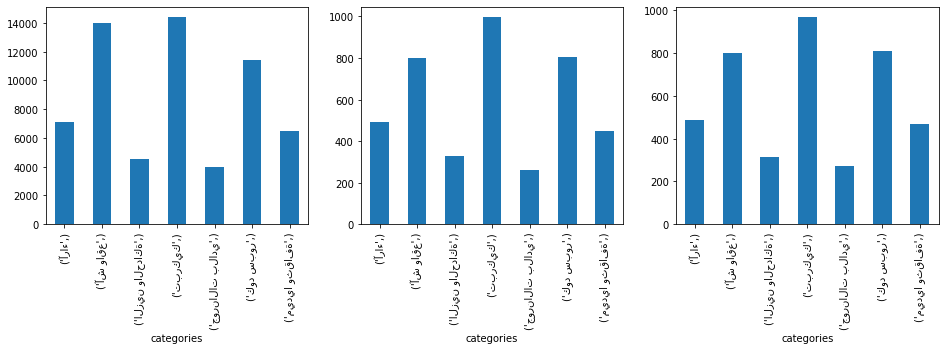

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(16,4))
train_data.groupby('categories')['headline'].count().plot.bar(ax=axs[0])
val_data.groupby('categories')['headline'].count().plot.bar(ax=axs[1])
test_data.groupby('categories')['headline'].count().plot.bar(ax=axs[2])

In [10]:
train_data["categories"].unique()

array(["('جورنالات بلادي',)", "('كود سبور',)", "('تبركيك',)", "('آراء',)",
       "('آش واقع',)", "('ميديا وثقافة',)", "('الزين والحداكة',)"],
      dtype=object)

In [ ]:
val_data["categories"].unique()

array(["('آش واقع',)", "('تبركيك',)", "('كود سبور',)", "('آراء',)",
       "('ميديا وثقافة',)", "('جورنالات بلادي',)", "('الزين والحداكة',)"],
      dtype=object)

In [ ]:
test_data["categories"].unique()

array(["('جورنالات بلادي',)", "('ميديا وثقافة',)", "('تبركيك',)",
       "('آش واقع',)", "('كود سبور',)", "('آراء',)",
       "('الزين والحداكة',)"], dtype=object)

In [11]:
from sklearn.utils import resample

def downsample(data, column, n_samples):

  column_df = data[data["categories"] == column]

  data.drop(data[data["categories"] == column].index, inplace=True)

  column_downsampled = resample(column_df, replace=True, n_samples=n_samples, random_state=42)

  data = pd.concat([column_downsampled, data], ignore_index=True).sort_index()

  return data

In [ ]:
# for categ in train_data["categories"].unique():
#   if categ not in ["('جورنالات بلادي',)", "('الزين والحداكة',)"]:
#     train_data = downsample(train_data, categ, 6000)

In [ ]:
# for categ in val_data["categories"].unique():
#   val_data = downsample(val_data, categ, 100)

In [ ]:
# for categ in test_data["categories"].unique():
#   test_data = downsample(test_data, categ, 100)

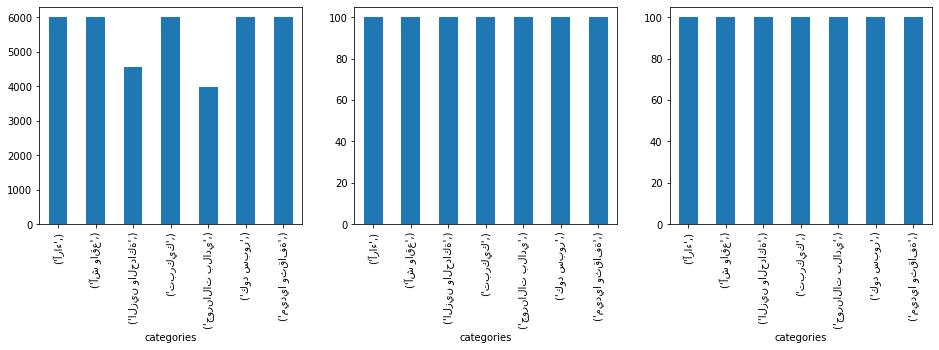

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
train_data.groupby('categories')['headline'].count().plot.bar(ax=axs[0])
val_data.groupby('categories')['headline'].count().plot.bar(ax=axs[1])
test_data.groupby('categories')['headline'].count().plot.bar(ax=axs[2])

In [12]:
def categ2label(categ):
  labels_dict = {
      "('جورنالات بلادي',)" : 0,
      "('كود سبور',)" : 1,
      "('تبركيك',)" : 2,
      "('آراء',)" : 3,
      "('آش واقع',)" : 4,
      "('ميديا وثقافة',)" : 5,
      "('الزين والحداكة',)" : 6,
  }
  return labels_dict[categ]

In [13]:
train_data["label"] = train_data["categories"].apply(categ2label)
val_data["label"] = val_data["categories"].apply(categ2label)
test_data["label"] = test_data["categories"].apply(categ2label)

In [14]:
train_data

,headline,categories,label
0,حكم ضد وزارة اعمارة بتعويض قدره 13 مليار لشركة,"('جورنالات بلادي',)",0
1,جلسة خاصة بين مدرب الأهلي ومهاجم الأسود أزارو,"('كود سبور',)",1
2,اعتقال مهاجم الريال رونالدو في فرنسا… وها علاش (صور),"('كود سبور',)",1
3,الأسود المحليين يستعدون للمربع الذهبي,"('كود سبور',)",1
4,الجديد.. ريحة ديال المازوط وليصونس لعشاق صوكَان وطوموبيلات,"('تبركيك',)",2
...,...,...,...
62005,واش دخلو الصهد؟. امحند العنصر لـ”كود”: مزال مقررت نترشح للأمانة العامة ديال الحركة الشعبية وها وقتاش غادي نقرر,"('تبركيك',)",2
62006,الفنانة المغربية ابتسام تسكت مطلوبة بوجدة‏,"('الزين والحداكة',)",6
62007,من بعد 15 العام.. تصوير تتمة فيلم “ماروك” لي كان نوض روينة,"('ميديا وثقافة',)",5
62008,جورنالات بلادي1. غموض يلف صرف 5 ملايير بمؤسسة الأعمال الاجتماعية بوزارة الصحة وأمن طنجة يعتقل زعيم عصابة بتهمة اختطاف زوجين واحتجازهما للمطالبة بفدية,"('جورنالات بلادي',)",0


In [15]:
train_headlines = train_data["headline"]
train_labels = train_data["label"]
val_headlines = val_data["headline"]
val_labels = val_data["label"]
test_headlines = test_data["headline"]
test_labels = test_data["label"]

In [16]:
%%capture
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")

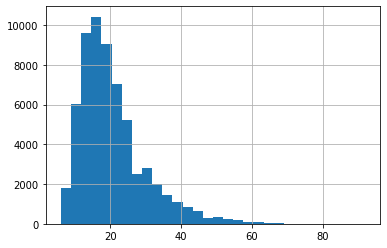

In [17]:
seq_len = [len(tokenizer.encode(i)) for i in train_headlines]

pd.Series(seq_len).hist(bins = 30)

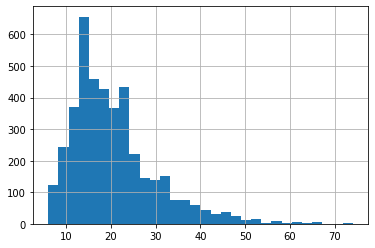

In [18]:
seq_len = [len(tokenizer.encode(i)) for i in val_headlines]

pd.Series(seq_len).hist(bins = 30)

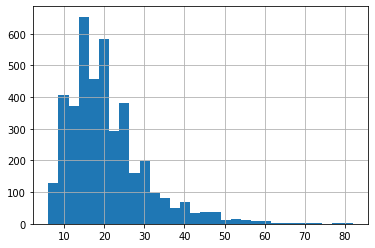

In [19]:
seq_len = [len(tokenizer.encode(i)) for i in test_headlines]

pd.Series(seq_len).hist(bins = 30)

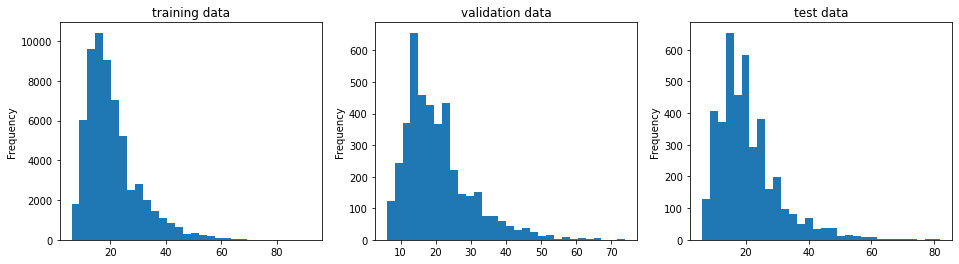

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
seq_len_train = [len(tokenizer.encode(i)) for i in train_headlines]
seq_len_val = [len(tokenizer.encode(i)) for i in val_headlines]
seq_len_test = [len(tokenizer.encode(i)) for i in test_headlines]

pd.Series(seq_len_train).plot(kind='hist', ax=axs[0], title='training data', xlabel='sequence length', ylabel='number of articles', bins=30)
pd.Series(seq_len_val).plot(kind='hist', ax=axs[1], title='validation data', xlabel='sequence length', ylabel='number of articles', bins=30)
pd.Series(seq_len_test).plot(kind='hist', ax=axs[2], title='test data', xlabel='sequence length', ylabel='number of articles', bins=30)

In [26]:
max_seq_len = 40

train_encodings = tokenizer(train_headlines.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_headlines.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_headlines.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [27]:
class ArticleDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ArticleDataset(train_encodings, train_labels)
val_dataset = ArticleDataset(val_encodings, val_labels)
test_dataset = ArticleDataset(test_encodings, test_labels)

In [28]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [29]:
%%capture
model = AutoModelForSequenceClassification.from_pretrained("SI2M-Lab/DarijaBERT", num_labels=7)

In [30]:
training_args = TrainingArguments(
    output_dir='drive/MyDrive/Internship/code/results_MAD',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    evaluation_strategy='epoch',     # evaluate at the end of each epoch
    logging_strategy='epoch',        # log at the end of each epoch
    save_strategy='epoch', 
    overwrite_output_dir=True,
    save_total_limit=3,
    seed=42,
    data_seed=42
    )

trainer = Trainer(
    model=model,                         # the instantiated Transformers model 
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics      # method we defined before to compute our metrics
    )

In [31]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.870000,0.706453,0.740392,0.740433,0.747473,0.740392
2,0.508300,0.722192,0.761663,0.764031,0.773297,0.761663
3,0.270000,0.867406,0.762630,0.763553,0.768703,0.762630
4,0.126900,1.109590,0.760696,0.760613,0.763140,0.760696
5,0.058600,1.373521,0.765047,0.765381,0.766977,0.765047


TrainOutput(global_step=9690, training_loss=0.3667705831143878, metrics={'train_runtime': 2646.1139, 'train_samples_per_second': 117.172, 'train_steps_per_second': 3.662, 'total_flos': 6373534763700000.0, 'train_loss': 0.3667705831143878, 'epoch': 5.0})

In [32]:
predictions, label_ids, metrics = trainer.predict(test_dataset)

In [33]:
metrics

{'test_accuracy': 0.7554691298006806,
 'test_f1': 0.7558971060734914,
 'test_loss': 1.4504857063293457,
 'test_precision': 0.757768356824816,
 'test_recall': 0.7554691298006806,
 'test_runtime': 9.1065,
 'test_samples_per_second': 451.767,
 'test_steps_per_second': 7.138}

In [34]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels.to_numpy()

In [35]:
y_true = test_labels.to_numpy()

In [36]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)

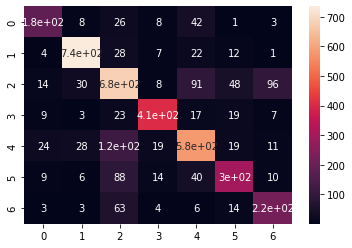

In [37]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
def categ2label(categ):
  labels_dict = {
      "('جورنالات بلادي',)" : 0,
      "('كود سبور',)" : 1,
      "('تبركيك',)" : 2,
      "('آراء',)" : 3,
      "('آش واقع',)" : 4,
      "('ميديا وثقافة',)" : 5,
      "('الزين والحداكة',)" : 6,
  }
  return labels_dict[categ]